In [1]:
from sctoolbox.utils.jupyter import bgcolor, _compare_version

nb_name = "GSEA.ipynb"

_compare_version(nb_name)

# Gene Set Enrichment Analysis (GSEA)
<hr style="border:2px solid black"> </hr>

## 1 - Description

**Requires an anndata object with precomputed marker genes. Marker genes can be generated with the marker gene notebook (`rna_analysis/notebooks/04_clustering.ipynb`).**

**Move this notebook into the notebook folder (e.g. `rna_analysis/notebooks/`) of the respective analysis before using it!**

The main function of this notebook is to perform enrichment analysis described as "\[...\] a computational method for inferring knowledge about an input gene set by comparing it to annotated gene sets representing prior biological knowledge."\[[source](https://maayanlab.cloud/Enrichr/help#background)\]. So in other words, the goal is to collect enriched GO pathways for clusters of cells (e.g. cell types) based on cluster defining sets of marker genes.  
Available methods for in this notebook are [Enrichr](https://maayanlab.cloud/Enrichr/) and [GSEA preank](https://www.genepattern.org/modules/docs/GSEAPreranked/1#gsc.tab=0), which are both implemented in [GSEApy](https://github.com/zqfang/GSEApy).

---

## 2 - Setup

In [2]:
from sctoolbox import settings

In [3]:
import sctoolbox.utils as utils
import sctoolbox.tools as tools
import sctoolbox.plotting as pl

import pandas as pd
import gseapy as gp
import tqdm
import matplotlib.pyplot as plt

---

## 3 - General Input

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [4]:
%bgcolor PowderBlue

from sctoolbox import settings

# sctoolbox settings
settings.adata_input_dir = "../rna_analysis/adatas/"
settings.adata_output_dir = "../rna_analysis/adatas/"
settings.figure_dir = "../figures/GSEA/"
settings.log_file = "../logs/GSEA_log.txt"
last_notebook_adata = "anndata_0A.h5ad"

# Define the dataset species!
organism = "human"

[WARNING] Log file '../logs/GSEA_log.txt' already exists. Logging messages will be appended to file. Set overwrite_log=True to overwrite the file.


---

## 4 - Load anndata

In [5]:
adata = utils.adata.load_h5ad(last_notebook_adata)

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

[INFO] The adata object was loaded from: ../rna_analysis/adatas/anndata_0A.h5ad


AnnData object with n_obs × n_vars = 2843 × 21149
    obs: 'orig.ident', 'chamber', 'donor', 'batch', 'sample', 'celltype', 'total_counts', 'log1p_total_counts', 'total_counts_is_mito', 'log1p_total_counts_is_mito', 'pct_counts_is_mito', 'total_counts_is_ribo', 'log1p_total_counts_is_ribo', 'pct_counts_is_ribo', 'total_counts_is_gender', 'log1p_total_counts_is_gender', 'pct_counts_is_gender', 'doublet_score', 'predicted_doublet', 'predicted_sex', 'n_genes', 'log1p_n_genes', 'S_score', 'G2M_score', 'phase', 'leiden', 'LISI_score_X_pca', 'LISI_score_X_umap', 'sample_density', 'phase_density', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'clustering', 'selection'
    var: 'is_mito', 'is_ribo', 'is_gender', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 

,orig.ident,chamber,donor,batch,sample,celltype,total_counts,log1p_total_counts,total_counts_is_mito,log1p_total_counts_is_mito,pct_counts_is_mito,total_counts_is_ribo,log1p_total_counts_is_ribo,pct_counts_is_ribo,total_counts_is_gender,log1p_total_counts_is_gender,pct_counts_is_gender,doublet_score,predicted_doublet,predicted_sex,n_genes,log1p_n_genes,S_score,G2M_score,phase,leiden,LISI_score_X_pca,LISI_score_X_umap,sample_density,phase_density,leiden_0.1,leiden_0.2,leiden_0.3,leiden_0.4,leiden_0.5,leiden_0.6,leiden_0.7,leiden_0.8,leiden_0.9,clustering,selection
NF2_RV_AGGTCTAGTAACTGCT,NF2_RV,B,2,1,2B,END,729.0,6.593045,4.0,1.609438,0.548697,2.0,1.098612,0.274348,16.0,2.833213,2.194787,0.036620,False,Female,572,6.350886,-0.066700,0.048457,G2M,3,1.034112,1.066608,0.445394,0.480471,2,2,3,3,3,3,3,4,4,3,NA
NF3_RV_CATTTCACAAGAGTTA,NF3_RV,B,3,1,3B,vCM,961.0,6.869014,5.0,1.791759,0.520291,4.0,1.609438,0.416233,18.0,2.944439,1.873049,0.089820,False,Male,857,6.754604,-0.054311,-0.050122,G1,1,1.281937,1.997140,0.927358,0.832711,1,1,1,1,1,1,1,2,2,1,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NF3_RV_CGAAGGAGTATCCCAA,NF3_RV,B,3,1,3B,vCM,846.0,6.741701,4.0,1.609438,0.472813,3.0,1.386294,0.354610,18.0,2.944439,2.127660,0.048170,False,Male,766,6.642487,-0.084897,0.059452,G2M,1,1.998908,1.865133,0.910685,0.989590,1,1,1,1,1,1,1,2,3,1,NA
NF2_RV_GAAATGAGTCGACGCT,NF2_RV,B,2,1,2B,FB,788.0,6.670766,4.0,1.609438,0.507614,6.0,1.945910,0.761421,28.0,3.367296,3.553300,0.033467,False,Female,610,6.415097,-0.093082,-0.123682,G1,0,1.997148,1.336631,0.744502,0.768525,1,1,2,2,2,2,2,1,1,2,NA


,is_mito,is_ribo,is_gender,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
gene,,,,,,,,,,,,,,,
AL627309.1,False,False,False,19,0.007738,0.007709,99.331692,22.0,3.135494,False,0.007530,0.203717,-0.119730,0.004976,0.061945
AC114498.1,False,False,False,1,0.000352,0.000352,99.964826,1.0,0.693147,False,0.000282,-0.220647,-1.931462,0.000207,0.011045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LINC01069,False,False,False,1,0.000352,0.000352,99.964826,1.0,0.693147,False,0.000298,-0.167246,-1.703479,0.000216,0.011497
GOLGA8Q,False,False,False,1,0.000352,0.000352,99.964826,1.0,0.693147,False,0.000294,-0.178783,-1.752732,0.000214,0.011398


---

## 5 - Select library

**Molecular Function**  
Molecular-level activities performed by gene products. Molecular function terms describe activities that occur at the molecular level, such as “catalysis” or “transport”. GO molecular function terms represent activities rather than the entities (molecules or complexes) that perform the actions, and do not specify where, when, or in what context the action takes place. Molecular functions generally correspond to activities that can be performed by individual gene products (i.e. a protein or RNA), but some activities are performed by molecular complexes composed of multiple gene products. Examples of broad functional terms are catalytic activity and transporter activity; examples of narrower functional terms are adenylate cyclase activity or Toll-like receptor binding. To avoid confusion between gene product names and their molecular functions, GO molecular functions are often appended with the word “activity” (a protein kinase would have the GO molecular function protein kinase activity).  

**Cellular Component**  
A location, relative to cellular compartments and structures, occupied by a macromolecular machine. There are two ways in which the gene ontology describes locations of gene products: (1) the cellular anatomical entities, in which a gene product carries out a molecular function. Cellular anatomical entities includes cellular structures such as the plasma membrane and the cytoskeleton, as well as membrane-enclosed cellular compartments such as the mitochondrion, and (2) the stable macromolecular complexes of which they are parts, e.g., the clathrin complex.  

**Biological Process**  
The larger processes, or ‘biological programs’ accomplished by multiple molecular activities. Examples of broad biological process terms are DNA repair or signal transduction. Examples of more specific terms are pyrimidine nucleobase biosynthetic process or glucose transmembrane transport. Note that a biological process is not equivalent to a pathway. At present, the GO does not try to represent the dynamics or dependencies that would be required to fully describe a pathway.

-- https://geneontology.org/docs/ontology-documentation/

**List of available librarys**

In [6]:
[db for db in gp.get_library_name(organism) if db.startswith("GO")]

['GO_Biological_Process_2013',
 'GO_Biological_Process_2015',
 'GO_Biological_Process_2017',
 'GO_Biological_Process_2017b',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_2021',
 'GO_Biological_Process_2023',
 'GO_Cellular_Component_2013',
 'GO_Cellular_Component_2015',
 'GO_Cellular_Component_2017',
 'GO_Cellular_Component_2017b',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_2021',
 'GO_Cellular_Component_2023',
 'GO_Molecular_Function_2013',
 'GO_Molecular_Function_2015',
 'GO_Molecular_Function_2017',
 'GO_Molecular_Function_2017b',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_2021',
 'GO_Molecular_Function_2023']

**List of available `marker_keys`**

In [7]:
[k for k in adata.uns.keys() if k.startswith("rank_genes")]

['rank_genes_groups',
 'rank_genes_groups_filtered',
 'rank_genes_leiden_0.1',
 'rank_genes_leiden_0.1_filtered']

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [8]:
%bgcolor PowderBlue

# key for marker table in adata.uns
marker_key = "rank_genes_leiden_0.1_filtered"  # The marker_key should match the clustering below.
clustering = "leiden_0.1"  # The marker_key is usually formatted as rank_genes_<clustering> or rank_genes_<clustering>_filtered.
pvals_adj_tresh = 0.05

# Select method. Available options: 'prerank', 'enrichr'
method = "prerank"

# Choose public library to use
library_name = "GO_Biological_Process_2023"

# If custom gene sets and background should be used set here.
# The public library will be ignored if custom_gene_set is given.
custom_gene_set = None  # {"Pathway 1": ["Gene1", "Gene2",...], ...}

# enrichr specific parameters
# To use a custom background for the public gene set library only set custom_background.
custom_background = None  # ["Gene 1", "Gene 2", ....]

# prerank specific parameters
threads = 4  # Number of threadsused by prerank function
min_size = 5  # Minimum allowed number of genes from gene set also the data set.
max_size = 1000  # Maximum allowed number of genes from gene set also the data set.
permutation_num = 1000  # Number of permutations.

---

## 6 - Run gene set enrichment analysis

In [9]:
combined = tools.gsea.gene_set_enrichment(adata,
                                          method=method,
                                          marker_key=marker_key,
                                          organism=organism,
                                          pvals_adj_tresh=pvals_adj_tresh,
                                          gene_sets=custom_gene_set,
                                          background=custom_background,
                                          library_name=library_name)

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/sctoolbox/tools/marker_genes.py:545: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gene
AL627309.1    0.003086
AC114498.1    0.000000
AL669831.5    0.015432
FAM87B        0.000000
LINC00115     0.003086
                ...   
AP003355.2    0.000000
LINC02458     0.000000
AL136301.1    0.000000
LINC01069     0.000000
GOLGA8Q       0.000000
Name: 2_fraction, Length: 21149, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  expressed.iloc[:, 0] = expressed.iloc[:, 0] / n_cells_dict[compare_group] if compare_group in n_cells_dict else 0
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/sctoolbox/tools/marker_genes.py:545: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gene
AL627309.1    0.004292
AC11

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/sctoolbox/tools/marker_genes.py:545: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gene
AL627309.1    0.005911
AC114498.1    0.000493
AL669831.5    0.015764
FAM87B        0.000000
LINC00115     0.001478
                ...   
AP003355.2    0.000493
LINC02458     0.000493
AL136301.1    0.000493
LINC01069     0.000493
GOLGA8Q       0.000493
Name: 1_fraction, Length: 21149, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  expressed.iloc[:, 0] = expressed.iloc[:, 0] / n_cells_dict[compare_group] if compare_group in n_cells_dict else 0
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/sctoolbox/tools/marker_genes.py:545: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'gene
AL627309.1    0.003086
AC11

  0%|          | 0/6 [00:00<?, ?it/s]2024-08-12 13:36:34,789 [INFO] Input gene rankings contains duplicated IDs
2024-08-12 13:36:34,794 [INFO] Parsing data files for GSEA.............................
2024-08-12 13:36:34,822 [INFO] 5343 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-08-12 13:36:34,823 [INFO] 0063 gene_sets used for further statistical testing.....
2024-08-12 13:36:34,824 [INFO] Start to run GSEA...Might take a while..................
2024-08-12 13:36:34,933 [INFO] Congratulations. GSEApy runs successfully................

 17%|█▋        | 1/6 [00:00<00:00,  6.53it/s]2024-08-12 13:36:34,941 [INFO] Input gene rankings contains duplicated IDs
2024-08-12 13:36:34,946 [INFO] Parsing data files for GSEA.............................
2024-08-12 13:36:34,969 [INFO] 5323 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-08-12 13:36:34,970 [INFO] 0083 gene_sets used for further statistical testing.....
2024-08-12 13:36:34,971 [INFO] S

---

## 7 - Plotting
<hr style="border:2px solid black"> </hr>

### 7.1 - Dotplot

The dotplot shows the top enriched pathways per cluster. The size of the dot indicates the fraction of genes in the cluster that match the pathway and the color of the dot indicates statistical significance (higher is better).

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [10]:
%bgcolor PowderBlue

# Dotplot
figsize = (10, 10)  # Set figure size for dotplot
top_term = 10  # Number of pathways shown per cluster
size = 2  # Size scale for dots

# Custom column to be plotted.
# If None uses default values:
#     prerank -> FDR q-val
#     enrichr -> "Adjusted P-value"
column = None

In [11]:
if column is None:
    column = "FDR q-val" if method == "prerank" else "Adjusted P-value"

---

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


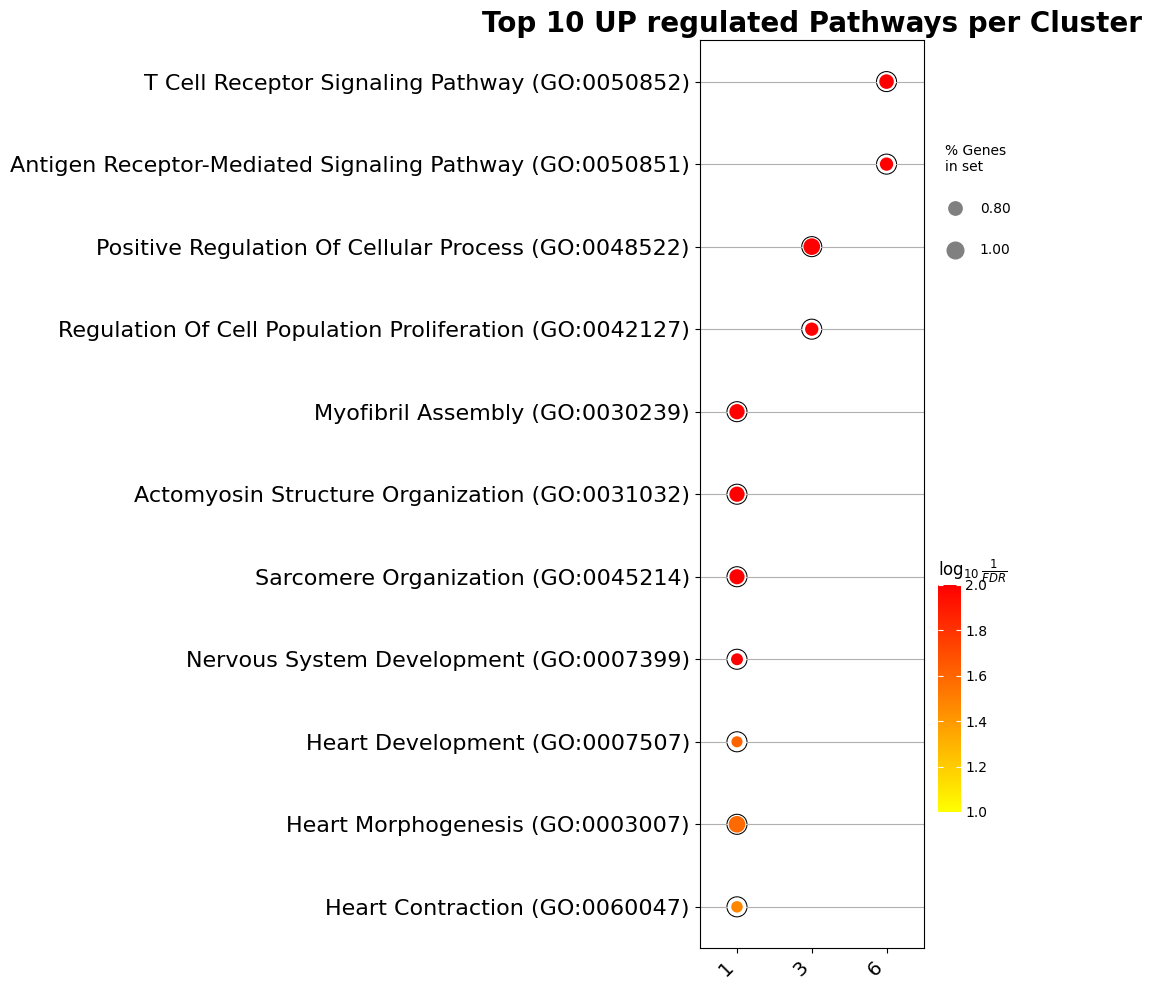

In [12]:
for reg in ["UP", "DOWN"]:
    comb = combined[combined["UP_DW"] == reg]
    if not comb.empty:
        ax = gp.dotplot(comb,
                        column=column,
                        figsize=figsize,
                        x='Cluster',
                        title=f"Top {top_term} {reg} regulated Pathways per Cluster",
                        cmap = plt.cm.autumn_r,
                        size=size,
                        show_ring=True,
                        top_term=top_term,
                        xticklabels_rot=45
                       )
        ax.set_xlabel("")
        plt.tight_layout()
        plt.savefig(f"{settings.figure_dir}/GSEA_dotplot_top{top_term}_{reg}_pathways_per_cluster.pdf", dpi=300)

---

### 7.2 - Term dotplot
The term dotplot focuses on a single term/pathway and thus shows individual genes instead of pathways on the y-axis. A Z-Score is applied to the mean gene expression per cluster to highlight differences in expression between the clusters (x-axis). A pathway of interest can be selected using the plot above.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [13]:
%bgcolor PowderBlue

# Term dotplot
term = "Actin Filament Organization (GO:0007015)"  # The GO term of interest.
groups = None  # Only show selected groups on x-axis e.g. ["a", "b"]. None to show all.
figsize_term_dot = None # Set figure size for term dotplot e.g. (10, 5).
save_term_dot = f"term_dotplot_{term}_{clustering}.pdf"

---

In [14]:
gene_col = "Lead_genes" if method == "prerank" else "Genes"

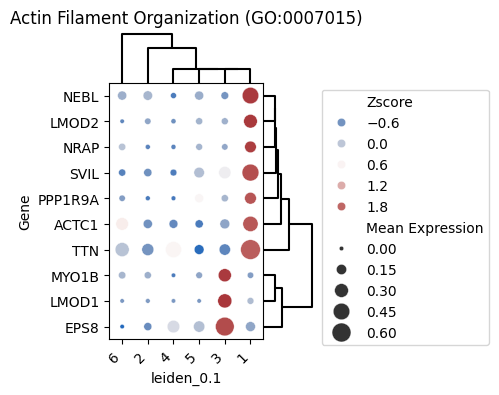

In [15]:
if term:
    pl.gsea.term_dotplot(term=term,
                         term_table=combined[combined["UP_DW"] == "UP"],
                         adata=adata,
                         groupby=clustering,
                         gene_col=gene_col,
                         groups=groups,
                         figsize=figsize_term_dot,
                         save=save_term_dot)

### 7.3 Network plot
The network plot shows connection of enrichted pathways per cluster. In the plot the node size corresponds to the percentage of gene overlap in a certain term of interest. The colour of the node corresponds to the significance of the enriched terms and the edge size corresponds to the number of genes that overlap between the two connected nodes.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [16]:
%bgcolor PowderBlue


cutoff = 0.05  # Cutoff for significance column
scale = 1  # Scale factor for node positions
figsize_network = None # Set figure size for term dotplot e.g. (10, 5). Set to None to use default.
ncols = 3  # Number of columns for network plots
save_network = f"pathway_network.pdf"

# Column containing significance of enrichted termn.
# If None uses default values:
#     prerank -> FDR q-val
#     enrichr -> "Adjusted P-value"
sig_column = None   

In [17]:
if sig_column is None:
    sig_column = "FDR q-val" if method == "prerank" else "Adjusted P-value"

---

/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(
/mnt/workspace2/rwiegan/conda_envs/sctoolbox/lib/python3.11/site-packages/gseapy/plot.py:689: FutureWarning: The 'method' keyword in Se

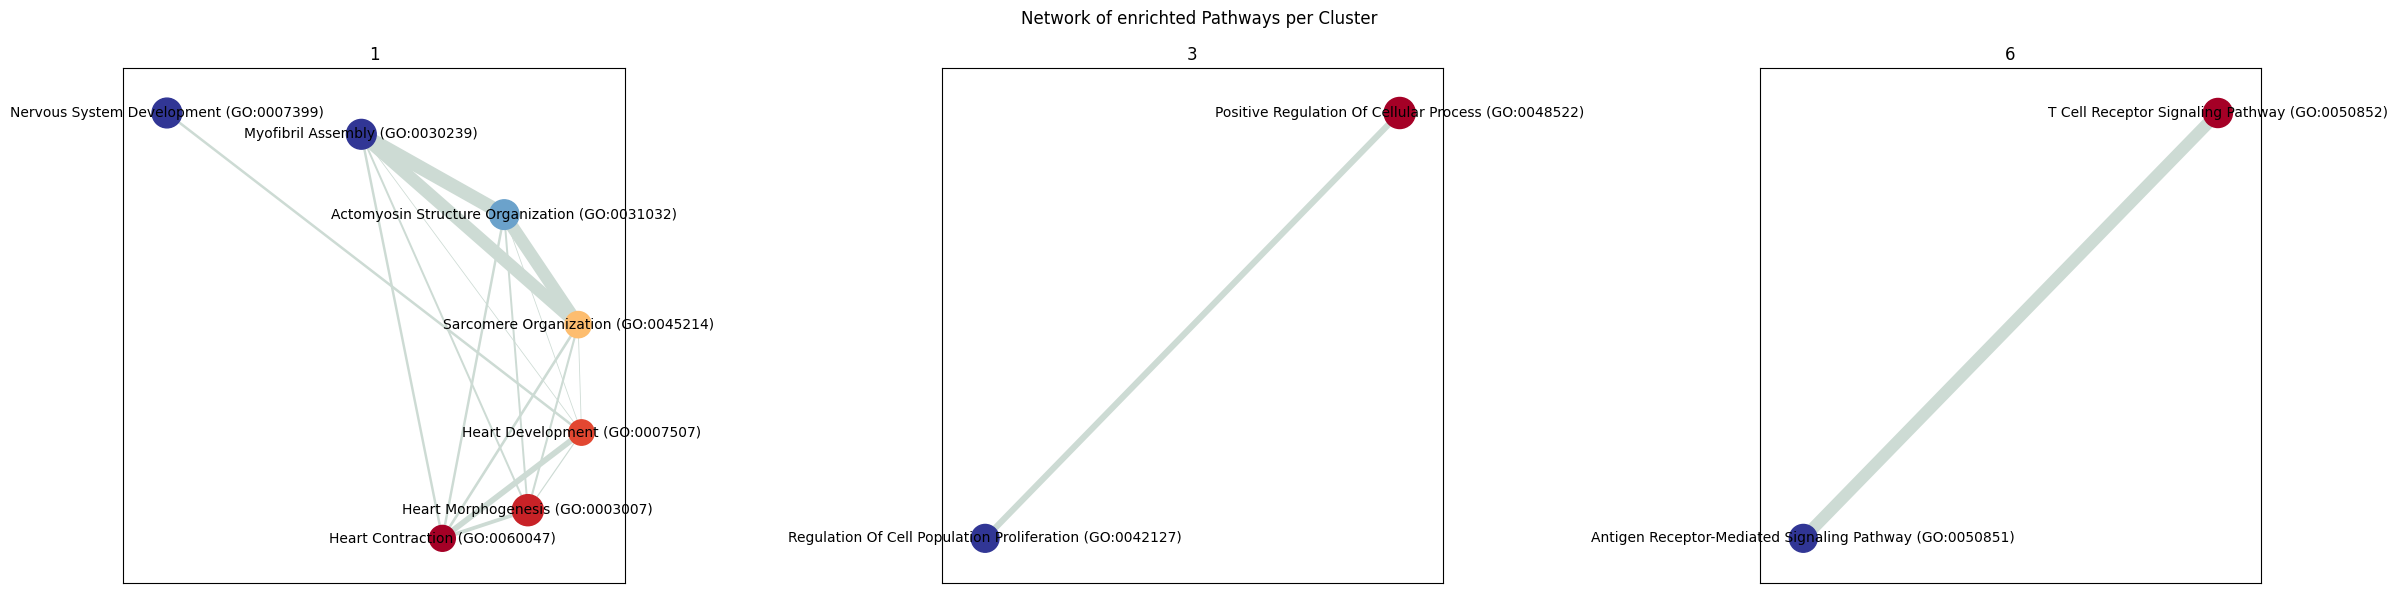

In [19]:
pl.gsea.gsea_network(combined[combined["UP_DW"] == "UP"], sig_col=sig_column,
                     cutoff=cutoff, scale=scale, figsize=figsize_network, ncols=ncols,
                     save=save_network)